In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random as rd
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Filepath to shared drive
filepath = '/content/drive/MyDrive/AANDA/Lab3/'

# Filepath to your own drive folder and files if it doesn't work
#filepath = ''

####General Functions

In [ ]:
#sgn function for the update
def sgn(x):
    return np.where(x >= 0, 1, -1)


#dispaly the patterns
def display(image, title=""):
    plt.figure()
    plt.imshow(image.reshape(32, 32), cmap='gray')
    plt.title(title)
    plt.show()


#generate the different patterns
def generate_data(d_type, bits=8):

    #non distorted original patterns stored
    if d_type == "real":
        x1d = [-1, -1, 1, -1, 1, -1, -1, 1]
        x2d = [-1, -1, -1, -1, -1, 1, -1, -1]
        x3d = [-1, 1, 1, -1, -1, 1, -1, 1]

        return np.vstack([x1d, x2d, x3d])

    #distorted patterns
    elif d_type == "distorted":
        x1d = [1, -1, 1, -1, 1, -1, -1, 1]  # one bit error
        x2d = [1, 1, -1, -1, -1, 1, -1, -1]  # two bit error
        x3d = [1, 1, 1, -1, 1, 1, -1, 1]  # two bit error

        return np.vstack([x1d, x2d, x3d])

    #very distorted patterns (more than 50% wrong)
    elif d_type == "very_distorted":
        x1d = [1, 1, -1, -1, -1, 1, -1, 1]
        x2d = [1, 1, 1, -1, -1, -1, 1, -1]
        x3d = [1, -1, -1, 1, -1, 1, -1, -1]

        return np.vstack([x1d, x2d, x3d])

    #all combinations in order to define attractors
    elif d_type == 'all_binary_comb':
        data = list(itertools.product([-1, 1], repeat=bits))

        return np.array(data)


#Returns data with p% of values flipped
def distort_data(data, p):
    distortedData=np.copy(data)
    if data.ndim==1:
        distortedData=distortedData.reshape((1,len(distortedData)))

    n=data.shape[1]
    nFlipped=math.floor(p/100*n)

    #Randomly flipps p% of each row in data
    for i in range(distortedData.shape[0]):
        flippedInd=np.random.choice(n, nFlipped, replace=False);
        distortedData[i,flippedInd]=distortedData[i,flippedInd]*-1

    return distortedData


#compute weights
def weights(x, sparsity=0, normalize=False):
    W = (x - sparsity).T @ (x - sparsity)
    if normalize:
        return W/x.shape[0]
    else:
        return W

#Add pattern to weights (Assumes weight is not normalized aka divided by 1/N)
def addPattern(x, w):
    if x.ndim==1:
        x=x.reshape((1,len(x)))
    n=x.shape[1]

    w+=np.outer(x.T,x);

    return w


#find the attractors
def find_attractors(x, w):
    data_updated = recall(x, w)
    attractors = np.unique(data_updated, axis=0)
    return attractors



#recall function - updating the units
def recall(x, w, update_type = "synchronous", iter = 1000,  sparsity = False, bias = 0, supress_output=False):

    #all units updated together
    if update_type == "synchronous":
        x_new = np.copy(x)
        x_current = np.copy(x)

        # Iterate for convergence
        for iteration in range(1, iter+1):

            #for each unit in the patterns update it
            if sparsity is True:
                x_new = 0.5 + 0.5 * sgn(x_current @ w - bias)

            else:
                x_new = sgn(x_current @ w)

            if not supress_output:
                #if the new patterns are the same, convergence reached
                if np.all(x_new == x_current):
                    print("The network converged after {} iterations.".format(iteration))
                    break

            #otherwise the new patterns become the "old" and start another iteration
            x_current = np.copy(x_new)


    #one unit updated at the time
    elif update_type == "asynchronous":
        x_new = np.copy(x)
        x_current = np.copy(x)

        #needed to print
        print_it = np.arange(iter/10, iter+1, iter/10).tolist()

        # Iterate for convergence
        for iteration in range(1,iter+1):

            #update just one unit
            for i in range(x.shape[0]):
                idx = np.random.randint(0, x.shape[1])  #one unit chosen randomly

                if sparsity is True:
                    x_new[i, idx] = 0.5 + 0.5 * sgn(x_current[i, :] @ w[idx] - bias)
                else:
                    x_new[i, idx] = sgn(x_current[i, :] @ w[idx])

            #Updates current value
            x_current = np.copy(x_new)

            if not supress_output:
                #print 10 images during the iterations
                if iteration in print_it:
                    display(x_current, "Recall after {} iterations.".format(iteration))


    return x_current

## Introduction

In [ ]:
x = generate_data("real")
print("Patterns", "\n", x, "\n")

W = weights(x)
print("Weight matrix", "\n", W, "\n")

x_new = recall(x, W)
print("Ability to store", "\n", x == x_new, "\n")

Patterns 
 [[-1 -1  1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]] 

Weight matrix 
 [[ 3  1 -1  3  1 -1  3 -1]
 [ 1  3  1  1 -1  1  1  1]
 [-1  1  3 -1  1 -1 -1  3]
 [ 3  1 -1  3  1 -1  3 -1]
 [ 1 -1  1  1  3 -3  1  1]
 [-1  1 -1 -1 -3  3 -1 -1]
 [ 3  1 -1  3  1 -1  3 -1]
 [-1  1  3 -1  1 -1 -1  3]] 

The network converged after 1 iterations.
Ability to store 
 [[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]] 



## 3.1

Distorted data

In [ ]:
x_distorted = generate_data("distorted")
print("Distorted Patterns", "\n", x_distorted, "\n")

x_new_distorted = recall(x_distorted, W)

print("Ability to store", "\n", x == x_new_distorted, "\n")

Distorted Patterns 
 [[ 1 -1  1 -1  1 -1 -1  1]
 [ 1  1 -1 -1 -1  1 -1 -1]
 [ 1  1  1 -1  1  1 -1  1]] 

The network converged after 3 iterations.
Ability to store 
 [[ True  True  True  True  True  True  True  True]
 [ True False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]] 



x1_distorted and x3_distorted converge towards to x1 and x3. x2_distorted doesn't converge to x2 exactly: they differ for one component

Very distorted data

In [ ]:
x_verydistorted = generate_data("very_distorted")
print("Very Distorted Patterns", "\n", x_verydistorted, "\n")

x_new_verydistorted = recall(x_verydistorted, W)

print("Ability to store", "\n", x == x_new_verydistorted, "\n")

Very Distorted Patterns 
 [[ 1  1 -1 -1 -1  1 -1  1]
 [ 1  1  1 -1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1  1 -1 -1]] 

The network converged after 3 iterations.
Ability to store 
 [[ True False  True  True False False  True  True]
 [False False False False False False False False]
 [False  True False False  True  True False False]] 



Attractors

In [ ]:
x_attractor = generate_data('all_binary_comb')
attractors = find_attractors(x_attractor, W)
print("\n", "The attractors are: ", attractors.shape[0])
print(attractors)

The network converged after 3 iterations.

 The attractors are:  14
[[-1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1  1 -1 -1  1 -1  1]
 [-1 -1  1 -1  1 -1 -1  1]
 [-1 -1  1 -1  1  1 -1  1]
 [-1  1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]
 [-1  1  1 -1  1 -1 -1  1]
 [ 1 -1 -1  1  1 -1  1 -1]
 [ 1  1 -1  1 -1  1  1 -1]
 [ 1  1 -1  1  1 -1  1 -1]
 [ 1  1 -1  1  1  1  1 -1]
 [ 1  1  1  1 -1  1  1  1]
 [ 1  1  1  1  1 -1  1  1]]


## 3.2

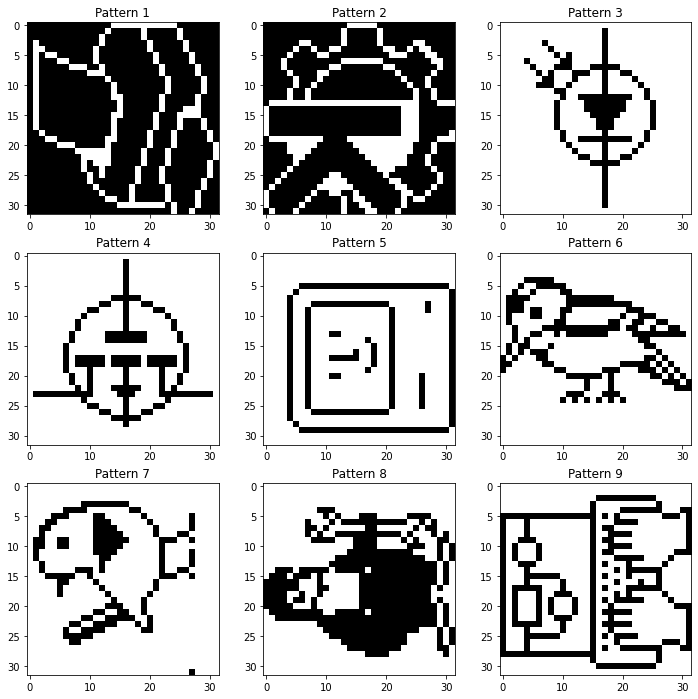

In [ ]:
data = np.loadtxt(filepath+'pict.dat', delimiter=",", dtype=int).reshape(-1, 1024)

# Learn the first 3 patterns
x = data[:3, :]
W = weights(x)

fig = plt.figure(figsize=(12,12))
for i, pattern in enumerate(data[:9,:]):
    fig.add_subplot(330+i+1)
    plt.imshow(pattern.reshape(32, 32), cmap='gray')
    plt.title("Pattern "+str(i+1))

The network converged after 2 iterations.
The network converged after 3 iterations.


Text(0.5, 1.0, 'Result Recall')

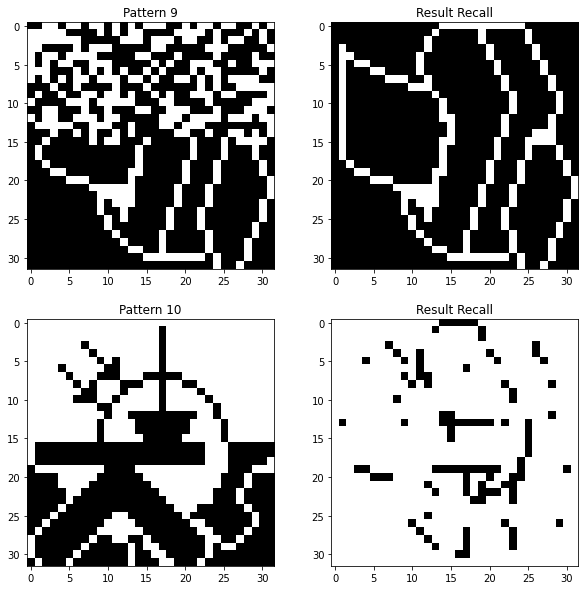

In [ ]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(221)
plt.imshow(data[9:10,:].reshape(32, 32), cmap='gray')
plt.title("Pattern 9")

fig.add_subplot(222)
data_new = recall(data[9:10,:],W)
plt.imshow(data_new.reshape(32, 32), cmap='gray')
plt.title("Result Recall")

fig.add_subplot(223)
plt.imshow(data[10:11,:].reshape(32, 32), cmap='gray')
plt.title("Pattern 10")

fig.add_subplot(224)
data_new = recall(data[10:11,:],W)
plt.imshow(data_new.reshape(32, 32), cmap='gray')
plt.title("Result Recall")

Pattern 9 convergences to its original pattern 1.

Pattern 10, which is the combination of two different patterns (2 and 3), doesn't converge to any initial pattern.

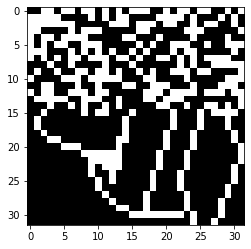

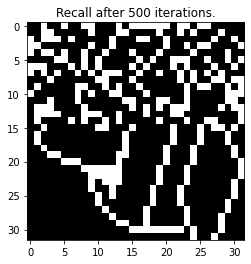

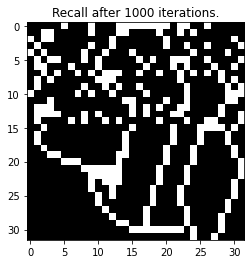

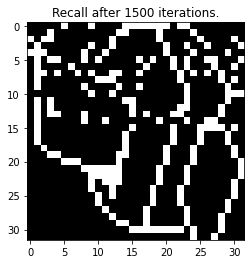

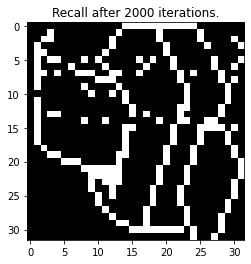

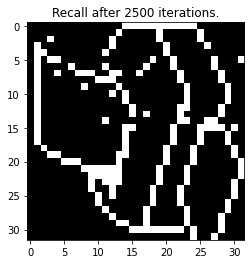

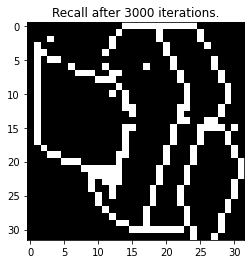

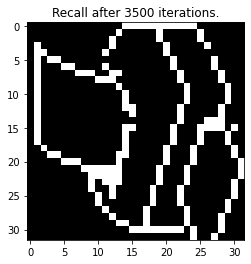

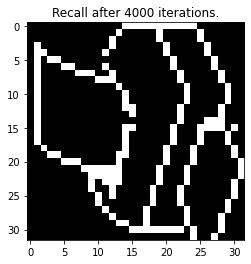

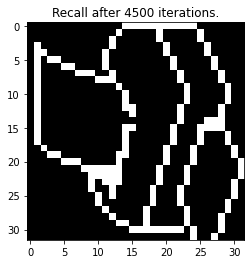

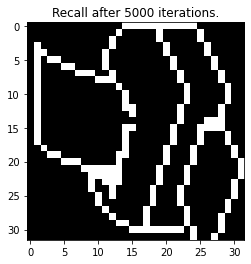

array([[-1, -1, -1, ..., -1, -1, -1]])

In [ ]:
display(data[9])
recall(data[9:10, :], W, update_type="asynchronous", iter = 5000)

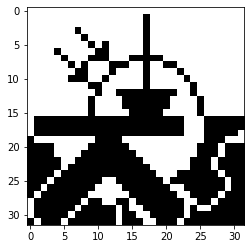

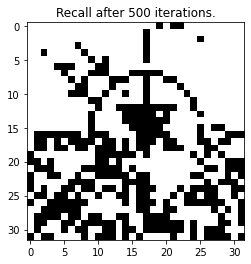

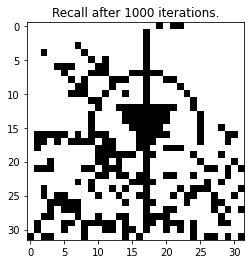

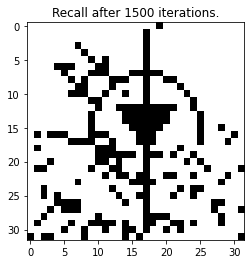

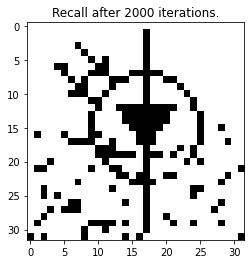

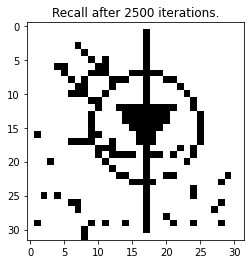

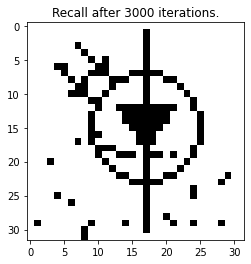

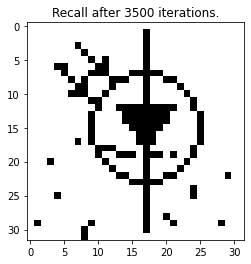

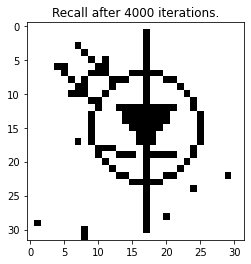

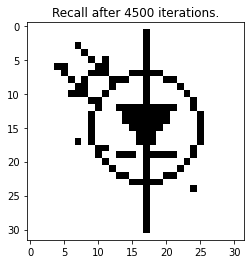

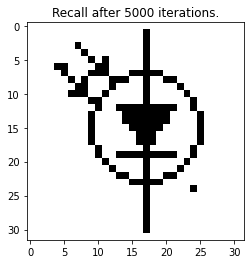

array([[1, 1, 1, ..., 1, 1, 1]])

In [ ]:
display(data[10])
recall(data[10:11, :], W, update_type="asynchronous", iter = 5000)

## 3.3

In [ ]:
def energy(w,x):       ### could be optimized
    e=0
    a,b=np.shape(w)
    for i in range(a):
        for j in range(b):
            e-=w[i][j]*x[0][i]*x[0][j]
    return(e)

In [ ]:
# Learn the first 3 patterns
x = data[:3, :]
W = weights(x)
energy(W,data[0:1, :])

-1473936

In [ ]:
#recall function - updating the units   ###add a tracking of the energy throught iterations
def recall_energy(x, w, update_type = "synchronous", iter = 1000):
    steps=[]
    e=[]
    #all units updated together
    if update_type == "synchronous":
        x_new = np.copy(x)
        x_current = np.copy(x)

        # Iterate for convergence
        for iteration in range(1, iter+1):

            #for each unit in the patterns update it
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    x_new[i, j] = sgn(x_current[i, :] @ w[j])

            #if the new patterns are the same, convergence reached
            if np.all(x_new == x_current):
                print("The network converged after {} iterations.".format(iteration))
                break

            #otherwise the new patterns become the "old" and start another iteration
            x_current = np.copy(x_new)


    #one unit updated at the time
    elif update_type == "asynchronous":
        x_new = np.copy(x)
        x_current = np.copy(x)

        #needed to print
        print_it = np.arange(iter/10, iter+1, iter/10).tolist()

        # Iterate for convergence
        for iteration in range(1,iter+1):

            #update just one unit
            for i in range(x.shape[0]):
                idx = np.random.randint(0, x.shape[1])  #one unit chosen randomly
                x_new[i, idx] = sgn(x_current[i, :] @ w[idx])

                #the new patterns become the "old" and start another iteration
                x_current = np.copy(x_new)
            if iteration%50==0:
                steps.append(iteration)
                e.append(energy(w,x_current))

    return x_current,steps,e

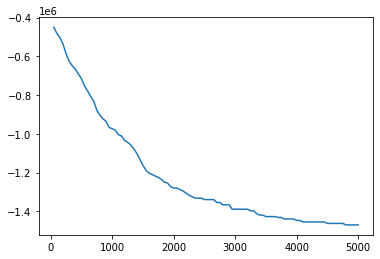

In [ ]:
p,xaxis,yaxis=recall_energy(data[9:10, :], W, update_type="asynchronous", iter = 5000)
plt.plot(xaxis,yaxis)

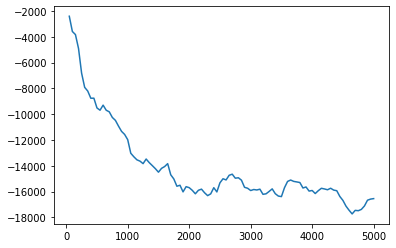

In [ ]:
#test with both a random W and a random pattern

W=np.random.normal(0,1,(1024,1024))

x=np.random.rand(1,1024)
for i in range(1024):
    if x[0][i]<0.5:
        x[0][i]=-1
    else:
        x[0][i]=1

p,xaxis,yaxis=recall_energy(x, W, update_type="asynchronous", iter = 5000)
plt.plot(xaxis,yaxis)

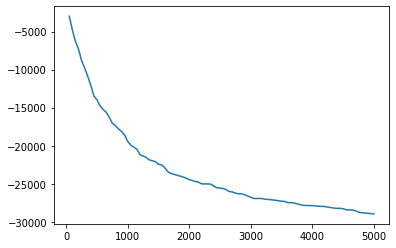

In [ ]:
#same with W now symetric

new_W=0.5*(W+np.transpose(W))

p,xaxis,yaxis=recall_energy(x, new_W, update_type="asynchronous", iter = 5000)
plt.plot(xaxis,yaxis)

##3.4

In [ ]:
def addNoise(x,p):   #each point has a p probabiliy of being flipped
    ra=np.random.rand(1024)
    new=x.copy()
    for i in range(1024):
        if ra[i]<p:
            new[0][i]=-1* new[0][i]
    return new

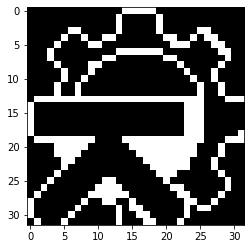

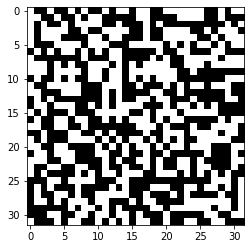

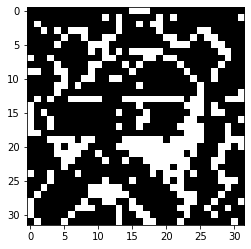

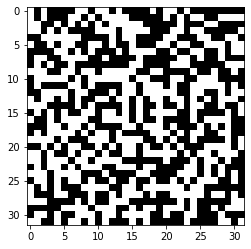

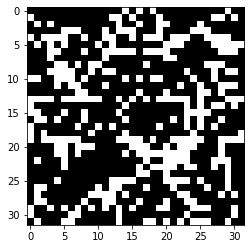

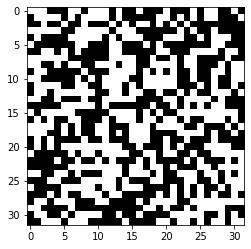

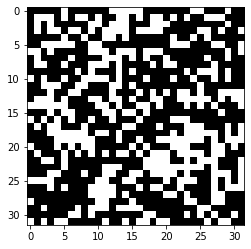

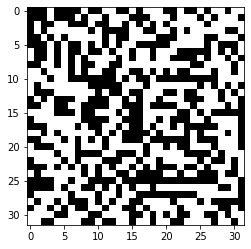

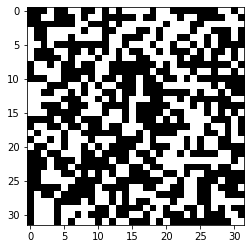

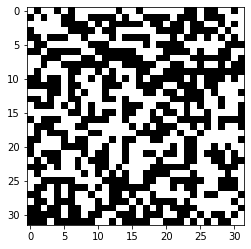

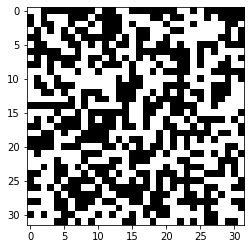

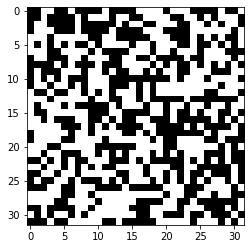

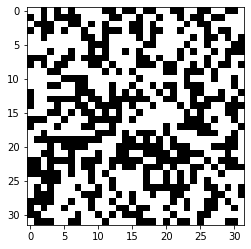

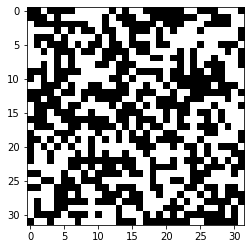

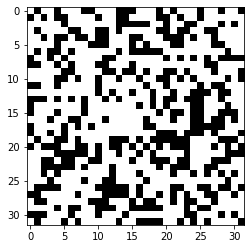

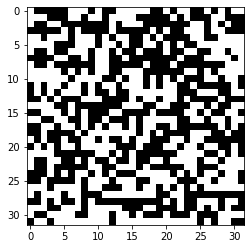

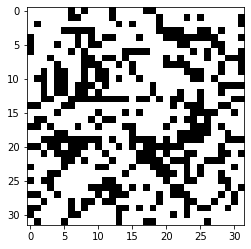

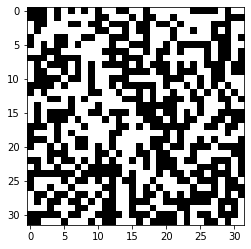

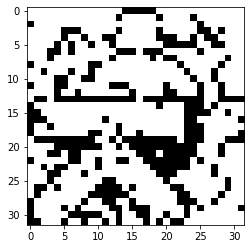

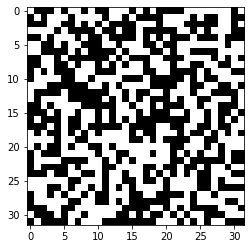

In [ ]:
x=data[1:2, :]
for k in range(10):
    n=addNoise(x,k/10)
    display(n)
    display(recall(n, W))

In [ ]:
def accuracy(xt,x):
    return 1-(np.count_nonzero(xt-x)/1024)

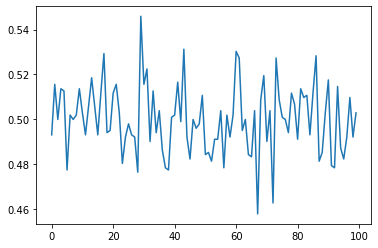

In [ ]:
x=data[2:3, :]
xaxis=[]
yaxis=[]
for k in range(100):
    n=addNoise(x,k/100)
    xaxis.append(k)
    yaxis.append(accuracy(recall(n, W),x))

plt.plot(xaxis,yaxis)

##3.5

In [ ]:
#return the percentage of the saved picture(s) which is returned correctly when distorted 'distortion' percent
def testDistortedMemorization(data, w, distortion, do_print=False):
    x=np.copy(data)
    if np.ndim==1:
        x=x.reshape((1,len(x)))

    n=data.shape[0]
    dim=data.shape[1]

    #Distorts data
    x_dist=distort_data(x, distortion)

    #Saves reconstruction rate
    reconstructionRate=np.zeros(n)
    x_recall = recall(x_dist, w)
    for i in range(len(reconstructionRate)):
        if do_print:
            display(x_recall[i])    #Shows the recreated picture
        value, number = np.unique(x[i]==x_recall[i], return_counts=True)

        if True in value:
            reconstructionRate[i]=number[np.where(value == True)]/dim
        else:
            reconstructionRate[i]=0

    return reconstructionRate



The network converged after 3 iterations.


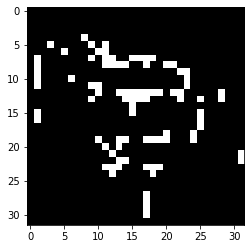

[0.83984375]
The network converged after 2 iterations.


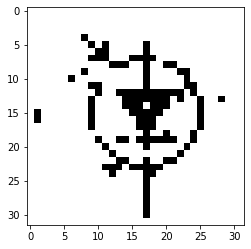

[0.96875]
The network converged after 2 iterations.


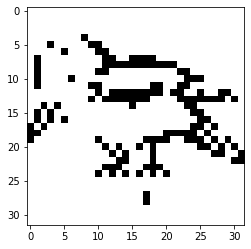

[0.9453125]
The network converged after 1 iterations.


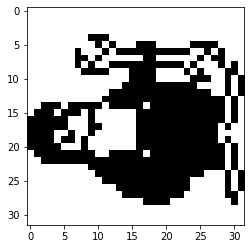

[1.]


In [ ]:
#Tests how many of the given patterns the network can store
#Test to memorize pictures 1,3, 6 and 8
w=weights(data[0:1,:])
w=addPattern(data[2:3,:], w)
w=addPattern(data[5:6,:], w)
w=addPattern(data[7:8,:], w)

print(testDistortedMemorization(data[0:1,:], w, 0, True))
print(testDistortedMemorization(data[2:3,:], w, 0, True))
print(testDistortedMemorization(data[5:6,:], w, 0, True))
print(testDistortedMemorization(data[7:8,:], w, 0, True))

It fails when trying to memorize more than 3 patterns even if there is no distortion. Tried a few different patterns to train with but the results were fairly consistent. The only thing of note is that some patterns seemed to perform better than others, the penguin for example succedes when all the other training patterns fails.

In [ ]:
#Tests how many random patterns the network can store

nTestedPictures=100
distortionPercentage=15

randomData=np.random.choice([-1, 1], size=(nTestedPictures, 32*32))
w=weights(randomData[:nTestedPictures,:])

recreationRate=testDistortedMemorization(randomData[:nTestedPictures,:], w, distortionPercentage)
print(recreationRate)
print(len(recreationRate))

The network converged after 5 iterations.
[0.99804688 1.         0.99804688 1.         1.         0.99902344
 1.         1.         1.         0.99902344 0.99902344 1.
 1.         1.         0.99902344 1.         1.         0.99902344
 0.99707031 1.         1.         0.99902344 1.         0.99707031
 1.         1.         0.99609375 0.99707031 1.         1.
 0.99707031 1.         0.99804688 1.         1.         0.99609375
 1.         0.99902344 1.         1.         1.         1.
 1.         0.99707031 0.99804688 1.         1.         0.99902344
 1.         0.99804688 0.99902344 1.         0.99804688 0.99414062
 0.99902344 1.         1.         1.         0.99902344 0.99902344
 0.99511719 1.         0.99804688 1.         0.99414062 0.99804688
 1.         1.         0.99414062 0.99902344 0.99902344 1.
 0.99804688 0.99316406 0.99804688 0.99902344 0.99902344 1.
 1.         1.         0.99707031 1.         0.99902344 0.99804688
 0.99902344 1.         0.99511719 1.         1.         0.99

Should really be visualized as a graph of how many patterns (on average) are correctly recalled with different distortion percentages. This will take ages to run. (It is what is shown in the next graphs just not on this particular network)

it is obvious that the network will have a way better memory when memorising white noise than pictures. I suspect this is because the white noise is not as correlated as the pictures and the network can only really memorize orthogonal patterns perfectly.

In [ ]:
#Plots the memory capacity as a function of added patterns (with different amount of distortion)

#Calculates the average
patternDimension=250
maxPatterns=100
maxIterations=50
distortionLevels=[0, 5, 10, 15, 20, 25]
nDistortions=len(distortionLevels)

recallPercentageOneStep=np.zeros((nDistortions, maxIterations, maxPatterns))
recallPercentageTenStep=np.zeros((nDistortions, maxIterations, maxPatterns))

#One step of recall
for d, distortion in enumerate(distortionLevels):
    for t in range(maxIterations):
        randomData=np.random.choice([-1, 1], size=(300, patternDimension))
        distData=distort_data(randomData, distortion)

        w=weights(randomData[:1,:])
        recallPercentageOneStep[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            oneIterationData=recall(distData[:i+1,:], w, iter=1, supress_output=True)

            count=0
            for j in range(i+1):
                if (oneIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageOneStep[d,t,i]=count/(i+1)

#Up to ten steps of recall
for d, distortion in enumerate(distortionLevels):
    for t in range(maxIterations):
        randomData=np.random.choice([-1, 1], size=(300, patternDimension))
        distData=distort_data(randomData, distortion)

        w=weights(randomData[:1,:])
        recallPercentageTenStep[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            tenIterationData=recall(distData[:i+1,:], w, iter=10, supress_output=True)

            count=0
            for j in range(i+1):
                if (tenIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageTenStep[d,t,i]=count/(i+1)

Text(0.5, 1.0, 'Ten Recall Steps')

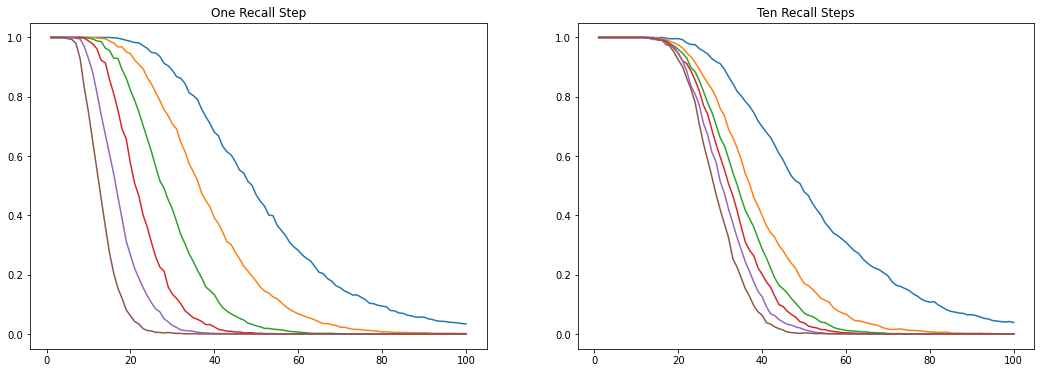

In [ ]:
#Plots the result
#Needs cleanup to look nice

fig = plt.figure(figsize=(18,6))

fig.add_subplot(121)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[4], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageOneStep[5], axis=0))
plt.title("One Recall Step")

fig.add_subplot(122)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[4], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageTenStep[5], axis=0))
plt.title("Ten Recall Steps")

In [ ]:
#Plots the memory capacity with self connections removed (both for one step in recall and a maximum of 10)

#Calculates the average
patternDimension=250
maxPatterns=100
maxIterations=50
distortionLevels=[0, 5, 10, 15, 20, 25]
nDistortions=len(distortionLevels)

recallPercentageNoSelfConnectionsOneStep=np.zeros((nDistortions, maxIterations, maxPatterns))
recallPercentageNoSelfConnectionsTenSteps=np.zeros((nDistortions, maxIterations, maxPatterns))

#One step of recall
for d, distortion in enumerate(distortionLevels):
    for t in range(maxIterations):
        randomData=np.random.choice([-1, 1], size=(300, patternDimension))
        distData=distort_data(randomData, distortion)

        w=weights(randomData[:1,:])
        w=w-np.eye(patternDimension)
        recallPercentageNoSelfConnectionsOneStep[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            w=w-np.eye(patternDimension)
            oneIterationData=recall(distData[:i+1,:], w, iter=1, supress_output=True)

            count=0
            for j in range(i+1):
                if (oneIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageNoSelfConnectionsOneStep[d,t,i]=count/(i+1)

#Up to ten steps of recall
for d, distortion in enumerate(distortionLevels):
    for t in range(maxIterations):
        randomData=np.random.choice([-1, 1], size=(300, patternDimension))
        distData=distort_data(randomData, distortion)

        w=weights(randomData[:1,:])
        w=w-np.eye(patternDimension)
        recallPercentageNoSelfConnectionsTenSteps[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            w=w-np.eye(patternDimension)
            tenIterationData=recall(distData[:i+1,:], w, iter=10, supress_output=True)

            count=0
            for j in range(i+1):
                if (tenIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageNoSelfConnectionsTenSteps[d,t,i]=count/(i+1)

Text(0.5, 1.0, 'Ten Recall Steps')

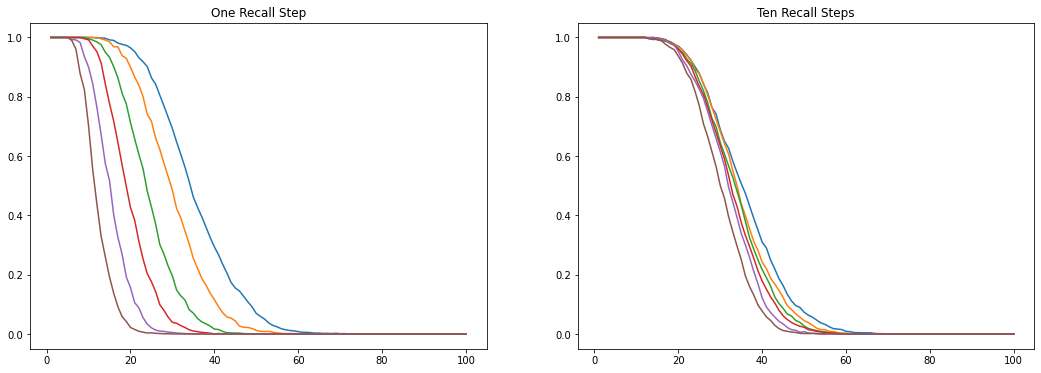

In [ ]:
#Plots the result
#Needs cleanup to look nice

fig = plt.figure(figsize=(18,6))

fig.add_subplot(121)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[4], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsOneStep[5], axis=0))
plt.title("One Recall Step")

fig.add_subplot(122)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[4], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageNoSelfConnectionsTenSteps[5], axis=0))
plt.title("Ten Recall Steps")

I need to plot.
* Patterns after (one and many recall)
* Patterns with weight removed (one and many recall)
* Biased random patterns (one and many recall)

In [ ]:
#Storage capacity on biased data

#Calculates the average
patternDimension=250
maxPatterns=100
maxIterations=100
biasLevels=[50, 60, 70, 80, 90]
nBias=len(biasLevels)

recallPercentageBiasedOneStep=np.zeros((nBias, maxIterations, maxPatterns))
recallPercentageBiasedNoSelfConnectionsOneStep=np.zeros((nBias, maxIterations, maxPatterns))

#With self connections
for d, bias in enumerate(biasLevels):
    for t in range(maxIterations):
        #Generates random data with a bias s.t. ~bias% is positive
        randomData=np.random.rand(300, patternDimension)-1.0+bias/100
        randomData=np.sign(randomData)

        w=weights(randomData[:1,:])
        recallPercentageBiasedOneStep[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            oneIterationData=recall(randomData[:i+1,:], w, iter=1, supress_output=True)

            count=0
            for j in range(i+1):
                if (oneIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageBiasedOneStep[d,t,i]=count/(i+1)

#With no self connections
for d, bias in enumerate(biasLevels):
    for t in range(maxIterations):
        #Generates random data with a bias s.t. ~bias% is positive
        randomData=np.random.rand(300, patternDimension)-1.0+bias/100
        randomData=np.sign(randomData)

        w=weights(randomData[:1,:])
        w=w-np.eye(patternDimension)
        recallPercentageBiasedNoSelfConnectionsOneStep[d,t,0] = 1.0
        for i in range(1,maxPatterns):
            w=addPattern(randomData[i:i+1,:], w)
            w=w-np.eye(patternDimension)
            oneIterationData=recall(randomData[:i+1,:], w, iter=1, supress_output=True)

            count=0
            for j in range(i+1):
                if (oneIterationData[j] == randomData[j]).all():
                    count+=1

            recallPercentageBiasedNoSelfConnectionsOneStep[d,t,i]=count/(i+1)

Text(0.5, 1.0, 'Without Self Connections')

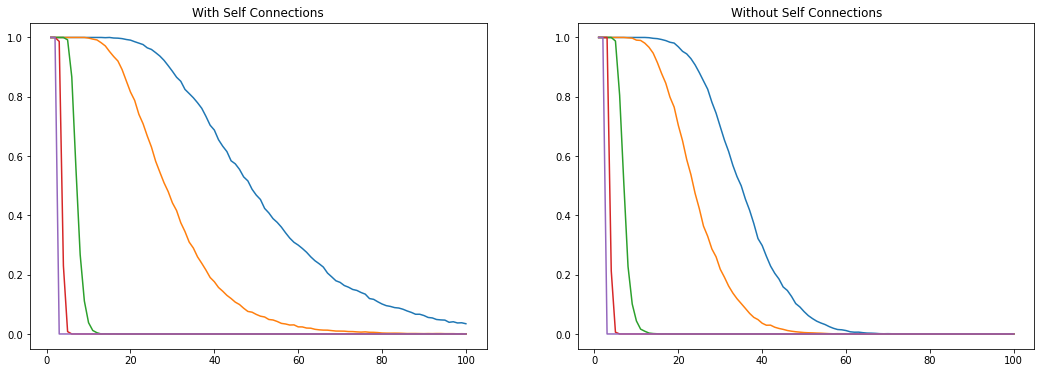

In [ ]:
#Plots the result
#Needs cleanup to look nice

fig = plt.figure(figsize=(18,6))

fig.add_subplot(121)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedOneStep[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedOneStep[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedOneStep[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedOneStep[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedOneStep[4], axis=0))
plt.title("With Self Connections")

fig.add_subplot(122)
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedNoSelfConnectionsOneStep[0], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedNoSelfConnectionsOneStep[1], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedNoSelfConnectionsOneStep[2], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedNoSelfConnectionsOneStep[3], axis=0))
plt.plot(np.arange(maxPatterns)+1, np.mean(recallPercentageBiasedNoSelfConnectionsOneStep[4], axis=0))
plt.title("Without Self Connections")

## 3.6

In [ ]:
#sparsity parameter (10%, 5% and 1% activity)
activity = [0.1, 0.05, 0.01]

10% Activity 
 Maximum number of memorized patterns - synchronous: 287 
 Maximum number of memorized patterns - asynchronous: 300


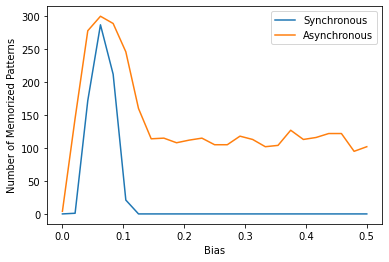

The bias value that supplies the most memorized patterns for synchronous is:  0.0208 

The bias value that supplies the most memorized patterns for asynchronous is:  0.0625


In [ ]:
np.random.seed(2)
random_patterns = np.random.choice([0, 1], [300, 100], p=[1-activity[0], activity[0]], replace=True)

stable_patterns = [[],[]]
training_patterns = random_patterns
W = weights(training_patterns, activity[0], normalize = True)

biases = np.linspace(0, 0.5, 25)
for bias in biases:
    n_stable_patterns = [0,0]

    for pattern in training_patterns:
        pattern = pattern.reshape(1,100)
        result_s = recall(pattern, W, update_type="synchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)
        result_a = recall(pattern, W, update_type="asynchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)

        if (np.array_equal(pattern, result_s)):
            n_stable_patterns[0] += 1
        if (np.array_equal(pattern, result_a)):
            n_stable_patterns[1] += 1

    stable_patterns[0].append(n_stable_patterns[0])
    stable_patterns[1].append(n_stable_patterns[1])

print("10% Activity", "\n", 'Maximum number of memorized patterns - synchronous: {}'.format(np.max(stable_patterns[0])), "\n",
      'Maximum number of memorized patterns - asynchronous: {}'.format(np.max(stable_patterns[1])))

plt.plot(biases, stable_patterns[0], label="Synchronous")
plt.plot(biases, stable_patterns[1], label = "Asynchronous")
plt.xlabel('Bias')
plt.ylabel('Number of Memorized Patterns')
plt.legend()
plt.show()

best_bias_s = round(biases[np.where(stable_patterns == np.max(stable_patterns))[0]][0],4)
best_bias_a = round(biases[np.where(stable_patterns == np.max(stable_patterns))[1]][0],4)
print("The bias value that supplies the most memorized patterns for synchronous is: ", best_bias_s, "\n")
print("The bias value that supplies the most memorized patterns for asynchronous is: ", best_bias_a)

5% Activity 
 Maximum number of memorized patterns - synchronous: 266 
 Maximum number of memorized patterns - asynchronous: 299


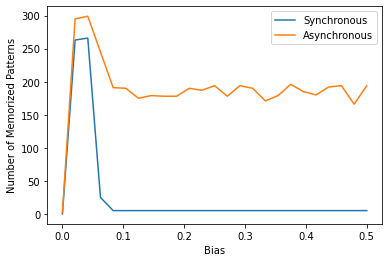

The bias value that supplies the most memorized patterns for synchronous is:  0.0208 

The bias value that supplies the most memorized patterns for asynchronous is:  0.0417


In [ ]:
np.random.seed(2)
random_patterns = np.random.choice([0, 1], [300, 100], p=[1-activity[1], activity[1]], replace=True)

stable_patterns = [[],[]]
training_patterns = random_patterns
W = weights(training_patterns, activity[1], normalize = True)

biases = np.linspace(0, 0.5, 25)
for bias in biases:
    n_stable_patterns = [0,0]

    for pattern in training_patterns:
        pattern = pattern.reshape(1,100)
        result_s = recall(pattern, W, update_type="synchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)
        result_a = recall(pattern, W, update_type="asynchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)

        if (np.array_equal(pattern, result_s)):
            n_stable_patterns[0] += 1
        if (np.array_equal(pattern, result_a)):
            n_stable_patterns[1] += 1

    stable_patterns[0].append(n_stable_patterns[0])
    stable_patterns[1].append(n_stable_patterns[1])

print("5% Activity", "\n", 'Maximum number of memorized patterns - synchronous: {}'.format(np.max(stable_patterns[0])), "\n",
      'Maximum number of memorized patterns - asynchronous: {}'.format(np.max(stable_patterns[1])))

plt.plot(biases, stable_patterns[0], label="Synchronous")
plt.plot(biases, stable_patterns[1], label = "Asynchronous")
plt.xlabel('Bias')
plt.ylabel('Number of Memorized Patterns')
plt.legend()
plt.show()

best_bias_s = round(biases[np.where(stable_patterns == np.max(stable_patterns))[0]][0],4)
best_bias_a = round(biases[np.where(stable_patterns == np.max(stable_patterns))[1]][0],4)
print("The bias value that supplies the most memorized patterns for synchronous is: ", best_bias_s, "\n")
print("The bias value that supplies the most memorized patterns for asynchronous is: ", best_bias_a)

1% Activity 
 Maximum number of memorized patterns - synchronous: 125 
 Maximum number of memorized patterns - asynchronous: 285


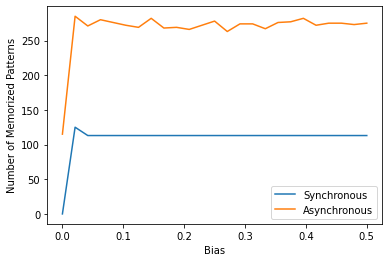

The bias value that supplies the most memorized patterns for synchronous is:  0.0208 

The bias value that supplies the most memorized patterns for asynchronous is:  0.0208


In [ ]:
np.random.seed(2)
random_patterns = np.random.choice([0, 1], [300, 100], p=[1-activity[2], activity[2]], replace=True)

stable_patterns = [[],[]]
training_patterns = random_patterns
W = weights(training_patterns, activity[2], normalize = True)

biases = np.linspace(0, 0.5, 25)
for bias in biases:
    n_stable_patterns = [0,0]

    for pattern in training_patterns:
        pattern = pattern.reshape(1,100)
        result_s = recall(pattern, W, update_type="synchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)
        result_a = recall(pattern, W, update_type="asynchronous", iter = 10, sparsity=True, bias = bias, supress_output=True)

        if (np.array_equal(pattern, result_s)):
            n_stable_patterns[0] += 1
        if (np.array_equal(pattern, result_a)):
            n_stable_patterns[1] += 1

    stable_patterns[0].append(n_stable_patterns[0])
    stable_patterns[1].append(n_stable_patterns[1])

print("1% Activity", "\n", 'Maximum number of memorized patterns - synchronous: {}'.format(np.max(stable_patterns[0])), "\n",
      'Maximum number of memorized patterns - asynchronous: {}'.format(np.max(stable_patterns[1])))

plt.plot(biases, stable_patterns[0], label="Synchronous")
plt.plot(biases, stable_patterns[1], label = "Asynchronous")
plt.xlabel('Bias')
plt.ylabel('Number of Memorized Patterns')
plt.legend()
plt.show()

best_bias_s = round(biases[np.where(stable_patterns == np.max(stable_patterns))[0]][0],4)
best_bias_a = round(biases[np.where(stable_patterns == np.max(stable_patterns))[1]][0],4)
print("The bias value that supplies the most memorized patterns for synchronous is: ", best_bias_s, "\n")
print("The bias value that supplies the most memorized patterns for asynchronous is: ", best_bias_a)